In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

# STEP 1: Load dataset
df = pd.read_csv(r'floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.sort_index()

# STEP 2: Basic Time Features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# STEP 3: Cyclical Time Encoding (for better modeling)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# STEP 4: Lag Features (memory of system)
df['lag_1'] = df['z1_AC1(kW)'].shift(1)
df['lag_5'] = df['z1_AC1(kW)'].shift(5)
df['lag_15'] = df['z1_AC1(kW)'].shift(15)
df['lag_30'] = df['z1_AC1(kW)'].shift(30)
df['lag_60'] = df['z1_AC1(kW)'].shift(60)
df['lag_120'] = df['z1_AC1(kW)'].shift(120)

# STEP 5: Rolling Statistics (trend/smoothing)
df['roll_mean_30'] = df['z1_AC1(kW)'].rolling(window=30).mean()
df['roll_std_30']  = df['z1_AC1(kW)'].rolling(window=30).std()
df['roll_mean_60'] = df['z1_AC1(kW)'].rolling(window=60).mean()
df['roll_std_60']  = df['z1_AC1(kW)'].rolling(window=60).std()

# STEP 6: Environmental Rolling Stats
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()

# STEP 7: Difference Features (inside - outside)
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
df['rh_diff'] = df['z1_S1(RH%)'] - df['Humidity'] if 'Humidity' in df.columns else np.nan

# STEP 8: Target (next hour's consumption)
df['target'] = df['z1_AC1(kW)'].shift(-60)

# STEP 9: Drop NA from rolling/lags/target shift
df = df.dropna()

# STEP 10: Feature list
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'hour_sin', 'hour_cos',
    'lag_1', 'lag_5', 'lag_15', 'lag_30', 'lag_60', 'lag_120',
    'roll_mean_30', 'roll_std_30', 'roll_mean_60', 'roll_std_60',
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
    'temp_diff', 'rh_diff'
]

# Prepare input/output
X = df[features]
y = df['target']


✅ Model Performance:
R² Score: 0.8036047879870053
MAE: 2.860493233544135
RMSE: 5.393746351814406


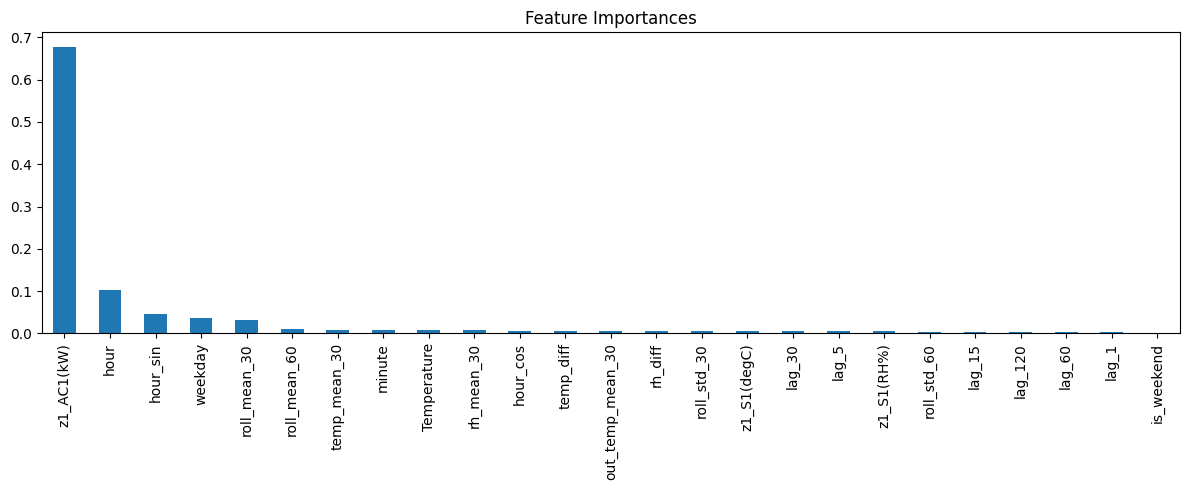

In [2]:

# STEP 11: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# STEP 12: Train XGBoost model
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, 'xgb_ac_consumption_model.pkl')

# STEP 13: Predict and evaluate
y_pred = model.predict(X_test)

print("✅ Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# STEP 14: Plot feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 5), title='Feature Importances')
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
import joblib
from datetime import timedelta

# Load model
model = joblib.load('xgb_ac_consumption_model.pkl')

# Load dataset again for feature generation
df = pd.read_csv(r'floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.sort_index()

# Extract base features (same as training)
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Lag features
df['lag_1'] = df['z1_AC1(kW)'].shift(1)
df['lag_5'] = df['z1_AC1(kW)'].shift(5)
df['lag_15'] = df['z1_AC1(kW)'].shift(15)
df['lag_30'] = df['z1_AC1(kW)'].shift(30)
df['lag_60'] = df['z1_AC1(kW)'].shift(60)
df['lag_120'] = df['z1_AC1(kW)'].shift(120)

# Rolling features
df['roll_mean_30'] = df['z1_AC1(kW)'].rolling(window=30).mean()
df['roll_std_30']  = df['z1_AC1(kW)'].rolling(window=30).std()
df['roll_mean_60'] = df['z1_AC1(kW)'].rolling(window=60).mean()
df['roll_std_60']  = df['z1_AC1(kW)'].rolling(window=60).std()

# Environmental rolling
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()

# Difference features
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
df['rh_diff'] = df['z1_S1(RH%)'] - df['Humidity'] if 'Humidity' in df.columns else np.nan

# Drop NA rows (from lagging/rolling)
df = df.dropna()

# Choose your date & time for prediction (e.g., "2023-08-21 14:00:00")
target_time = pd.Timestamp("2019-10-21 14:00:00")

# Ensure timestamp is present
if target_time not in df.index:
    raise ValueError(f"Timestamp {target_time} not found in data. Try a different date/time.")

# Feature list (same as model training)
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'hour_sin', 'hour_cos',
    'lag_1', 'lag_5', 'lag_15', 'lag_30', 'lag_60', 'lag_120',
    'roll_mean_30', 'roll_std_30', 'roll_mean_60', 'roll_std_60',
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
    'temp_diff', 'rh_diff'
]

# Get feature values for this timestamp
X_single = df.loc[[target_time], features]

# Predict next hour's consumption
y_pred_single = model.predict(X_single)

print(f"📅 Prediction for: {target_time}")
print(f"⚡️ Predicted AC Consumption (next hour): {y_pred_single[0]:.2f} kW")


📅 Prediction for: 2019-10-21 14:00:00
⚡️ Predicted AC Consumption (next hour): 28.40 kW


C:\Users\welcome\AppData\Local\Temp\ipykernel_11908\3098576359.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_times = pd.date_range(start=target_time, periods=60, freq='T')


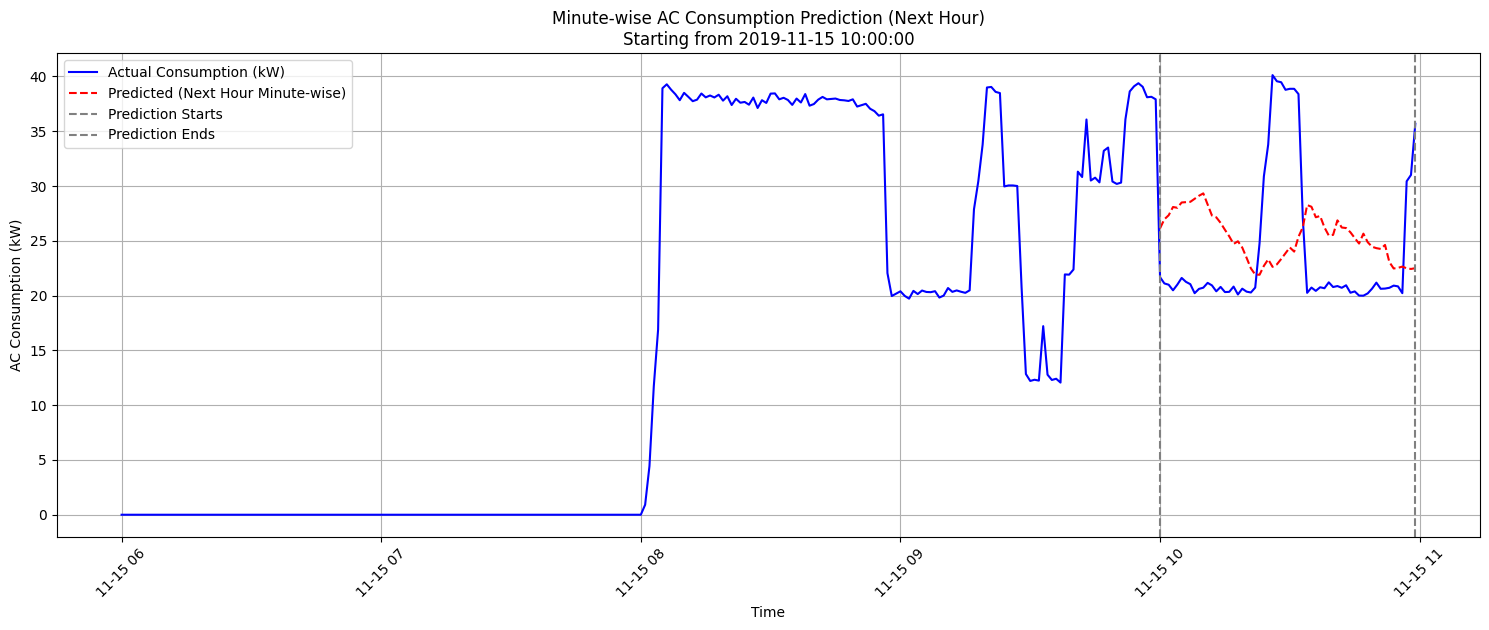

In [16]:
import matplotlib.pyplot as plt

# Set target timestamp
target_time = pd.Timestamp("2019-11-15 10:00:00")

# Define time range for context (past 4 hrs to end of prediction)
lookback_minutes = 60 * 4
start_time = target_time - pd.Timedelta(minutes=lookback_minutes)
end_time = target_time + pd.Timedelta(minutes=59)

# Build minute-wise predictions from target_time to target_time + 59 minutes
minute_preds = []
minute_times = pd.date_range(start=target_time, periods=60, freq='T')

for minute in minute_times:
    # Check if all features are available at this timestamp
    if minute not in df.index:
        minute_preds.append(np.nan)
        continue
    try:
        row = df.loc[minute]
        input_vector = row[features].values.reshape(1, -1)
        pred = model.predict(input_vector)[0]
        minute_preds.append(pred)
    except:
        minute_preds.append(np.nan)

# Prepare data for plotting
plot_df = df[['z1_AC1(kW)']].copy()
plot_df = plot_df[(plot_df.index >= start_time) & (plot_df.index <= end_time)].copy()
plot_df['Predicted'] = np.nan

# Fill predictions into the 'Predicted' column
for t, pred in zip(minute_times, minute_preds):
    if t in plot_df.index:
        plot_df.loc[t, 'Predicted'] = pred
    else:
        # If not already in index, add row
        plot_df.loc[t] = [np.nan, pred]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(plot_df.index, plot_df['z1_AC1(kW)'], label='Actual Consumption (kW)', color='blue')
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted (Next Hour Minute-wise)', color='red', linestyle='--')

# Highlight prediction window
plt.axvline(x=target_time, color='gray', linestyle='--', label='Prediction Starts')
plt.axvline(x=target_time + pd.Timedelta(minutes=59), color='gray', linestyle='--', label='Prediction Ends')

plt.title(f"Minute-wise AC Consumption Prediction (Next Hour)\nStarting from {target_time}")
plt.xlabel("Time")
plt.ylabel("AC Consumption (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
